# MindInsight训练看板

[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/notebook/mindinsight/mindinsight_dashboard.ipynb)

通过MindSpore可以将训练过程中的标量、图像、参数分布直方图、张量、计算图和数据图记录到summary日志文件中，并通过MindInsight提供的可视化界面进行查看。

- 通过查看特定的标量数值随着训练步骤的变化趋势，比如查看每个迭代的损失值、正确率、准确率这些标量的变化过程，追踪神经网络在整个训练过程中的信息，帮助用户了解模型是否过拟合，或者是否训练了过长时间。可以通过比较不同训练中的这些指标，以帮助调试和改善模型。

- 通过查看训练过程中的图像数据，用户可以查看每个步骤所使用的数据集图像。

- 参数分布直方图支持以直方图的形式呈现Tensor的变化趋势，用户可以查看训练过程中每个训练步骤的权重、bias和梯度参数变化信息。

- 张量可视能够帮助用户直观查看训练过程中某个步骤的Tensor值，Tensor包括权重值、梯度值、激活值等。

- 计算图的生成是通过将模型训练过程中的每个计算节点关联后所构成的，用户可以通过查看计算图，掌握整个模型的计算走向结构，数据流以及控制流的信息。对于高阶的使用人员，能够通过计算图验证计算节点的输入输出是否正确，并验证整个计算过程是否符合预期。

- 数据图展示的是数据预处理的过程，在MindInsight可视化面板中可查看数据处理的图，能够更加直观地查看数据预处理的每一个环节，并帮助提升模型性能。

接下来是本次流程的体验过程。

## 整体流程

1. 下载CIFAR-10二进制格式数据集。
2. 对数据进行预处理。
3. 定义AlexNet网络，在网络中使用summary算子记录数据。
4. 训练网络，使用 `SummaryCollector` 记录损失值标量、权重梯度、计算图和数据图参数。同时启动MindInsight服务，实时查看损失值、参数直方图、输入图像、张量、计算图和数据图的变化。
5. 完成训练后，查看MindInsight看板中记录到的损失值标量、直方图、图像信息、张量、计算图、数据图信息。
6. 相关注意事项，关闭MindInsight服务。

## 准备环节

### 下载数据集

本次流程使用CIFAR-10二进制格式数据集，下载地址为：<https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz>。

CIFAR-10二进制格式数据集包含10个类别的60000个32x32彩色图像。每个类别6000个图像，包含50000张训练图像和10000张测试图像。数据集分为5个训练批次和1个测试批次，每个批次具有10000张图像。测试批次包含每个类别中1000个随机选择的图像，训练批次按随机顺序包含剩余图像（某个训练批次包含的一类图像可能比另一类更多）。其中，每个训练批次精确地包含对应每个类别的5000张图像。

执行下面一段代码下载CIFAR-10二进制格式数据集到当前工作目录，如果已经下载过数据集，则不重复下载。

In [1]:
import os
import shutil
import urllib.request
from urllib.parse import urlparse


def callbackfunc(blocknum, blocksize, totalsize):
    percent = 100.0 * blocknum * blocksize / totalsize
    percent = min(percent, 100)
    print("downloaded {:.1f}".format(percent), end="\r")

def _download_dataset():
    ds_url = "https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz"
    file_base_name = urlparse(ds_url).path.split("/")[-1]
    file_name = os.path.join("./datasets", file_base_name)
    if not os.path.exists(file_name):
        urllib.request.urlretrieve(ds_url, file_name, callbackfunc)
    print("{:*^40}".format("DataSets Downloaded"))
    shutil.unpack_archive(file_name, extract_dir="./datasets/cifar-10-binary")

def _copy_dataset(ds_part, dest_path):
    data_source_path = "./datasets/cifar-10-binary/cifar-10-batches-bin"
    ds_part_source_path = os.path.join(data_source_path, ds_part)
    if not os.path.exists(ds_part_source_path):
        _download_dataset()
    shutil.copy(ds_part_source_path, dest_path)

def download_cifar10_dataset():
    ds_base_path = "./datasets/cifar10"
    train_path = os.path.join(ds_base_path, "train")
    test_path = os.path.join(ds_base_path, "test")
    print("{:*^40}".format("Checking DataSets Path."))
    if not os.path.exists(train_path) and not os.path.exists(test_path):
        os.makedirs(train_path)
        os.makedirs(test_path)
    print("{:*^40}".format("Downloading CIFAR-10 DataSets."))
    for i in range(1, 6):
        train_part = "data_batch_{}.bin".format(i)
        if not os.path.exists(os.path.join(train_path, train_part)):
            _copy_dataset(train_part, train_path)
        pops = train_part + " is ok"
        print("{:*^40}".format(pops))
    test_part = "test_batch.bin"
    if not os.path.exists(os.path.join(test_path, test_part)):
        _copy_dataset(test_part, test_path)
    print("{:*^40}".format(test_part+" is ok"))
    print("{:*^40}".format("Downloaded CIFAR-10 DataSets Already."))

download_cifar10_dataset()

********Checking DataSets Path.*********
*****Downloading CIFAR-10 DataSets.*****
*********data_batch_1.bin is ok*********
*********data_batch_2.bin is ok*********
*********data_batch_3.bin is ok*********
*********data_batch_4.bin is ok*********
*********data_batch_5.bin is ok*********
**********test_batch.bin is ok**********
*Downloaded CIFAR-10 DataSets Already.**


下载数据集后，CIFAR-10数据集目录（`datasets`）结构如下所示。

```text
    $ tree datasets
    datasets
    └── cifar10
        ├── test
        │   └── test_batch.bin
        └── train
            ├── data_batch_1.bin
            ├── data_batch_2.bin
            ├── data_batch_3.bin
            ├── data_batch_4.bin
            └── data_batch_5.bin
```

其中：

- `test_batch.bin`文件为测试数据集文件。
- `data_batch_1.bin`文件为第1批次训练数据集文件。
- `data_batch_2.bin`文件为第2批次训练数据集文件。
- `data_batch_3.bin`文件为第3批次训练数据集文件。
- `data_batch_4.bin`文件为第4批次训练数据集文件。
- `data_batch_5.bin`文件为第5批次训练数据集文件。

## 数据处理

好的数据集可以有效提高训练精度和效率，在加载数据集前，会进行一些处理，增加数据的可用性和随机性。下面一段代码定义函数`create_dataset_cifar10`来进行数据处理操作，并创建训练数据集(`ds_train`)和测试数据集(`ds_eval`)。

In [2]:
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore import dtype as mstype


def create_dataset_cifar10(data_path, batch_size=32, repeat_size=1, status="train"):
    """
    create dataset for train or test
    """
    cifar_ds = ds.Cifar10Dataset(data_path)
    rescale = 1.0 / 255.0
    shift = 0.0

    resize_op = CV.Resize(size=(227, 227))
    rescale_op = CV.Rescale(rescale, shift)
    normalize_op = CV.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    if status == "train":
        random_crop_op = CV.RandomCrop([32, 32], [4, 4, 4, 4])
        random_horizontal_op = CV.RandomHorizontalFlip()
    channel_swap_op = CV.HWC2CHW()
    typecast_op = C.TypeCast(mstype.int32)
    cifar_ds = cifar_ds.map(operations=typecast_op, input_columns="label")
    if status == "train":
        cifar_ds = cifar_ds.map(operations=random_crop_op, input_columns="image")
        cifar_ds = cifar_ds.map(operations=random_horizontal_op, input_columns="image")
    cifar_ds = cifar_ds.map(operations=resize_op, input_columns="image")
    cifar_ds = cifar_ds.map(operations=rescale_op, input_columns="image")
    cifar_ds = cifar_ds.map(operations=normalize_op, input_columns="image")
    cifar_ds = cifar_ds.map(operations=channel_swap_op, input_columns="image")

    cifar_ds = cifar_ds.shuffle(buffer_size=1000)
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_size)
    return cifar_ds

ds_train = create_dataset_cifar10(data_path="./datasets/cifar10/train")
ds_eval = create_dataset_cifar10("./datasets/cifar10/test")

### 抽取数据集图像

执行以下一段代码，抽取上步创建好的训练数据集`ds_train`中第一个`batch`的32张图像以及对应的类别名称进行展示。

The 32 images with label of the first batch in ds_train are showed below:


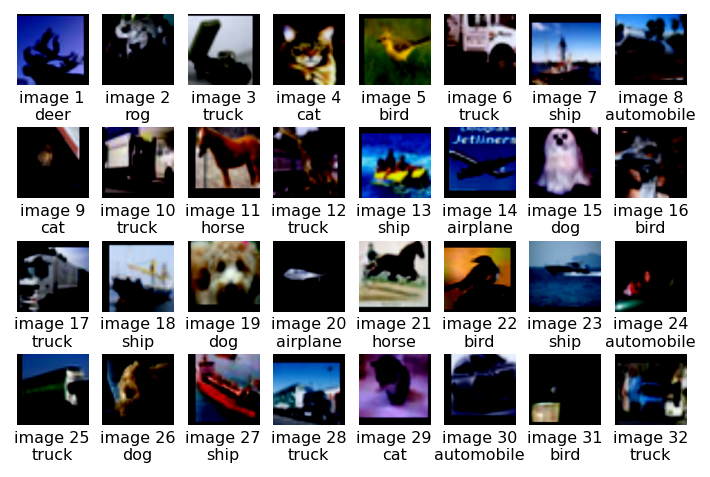

In [3]:
from matplotlib import pyplot as plt
import numpy as np

label_list = ["airplane", "automobile", "bird", "cat", "deer", "dog", "rog", "horse", "ship", "truck"]
print("The 32 images with label of the first batch in ds_train are showed below:")
ds_iterator = ds_train.create_dict_iterator()
next(ds_iterator)
batch_1 = next(ds_iterator)
batch_image = batch_1["image"].asnumpy()
batch_label = batch_1["label"].asnumpy()
%matplotlib inline
plt.figure(dpi=144)
for i, image in enumerate(batch_image):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    image = image/np.amax(image)
    image = np.clip(image, 0, 1)
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    num = batch_label[i]
    plt.title(f"image {i+1}\n{label_list[num]}", y=-0.65, fontdict={"fontsize": 8})
    plt.axis('off')
plt.show()

## 使用Summary算子记录数据

在进行训练之前，需定义神经网络模型，本流程采用AlexNet网络。

MindSpore提供了两种方法进行记录数据，分别为：

- 通过Summary算子记录数据。
- 通过 `SummaryCollector` 这个callback进行记录。

下面为在AlexNet网络中使用Summary算子记录输入图像和张量数据的配置方法。

- 使用 `ImageSummary` 记录输入图像数据。

    1. 在 `__init__` 方法中初始化 `ImageSummary`。

        ```python
        # Init ImageSummary
        self.image_summary = ops.ImageSummary()
        ```

    2. 在 `construct` 方法中使用 `ImageSummary` 算子记录输入图像。其中 "Image" 为该数据的名称，MindInsight在展示时，会将该名称展示出来以方便识别是哪个数据。

        ```python
        # Record image by Summary operator
        self.image_summary("Image", x)
        ```

- 使用 `TensorSummary` 记录张量数据。

    1. 在 `__init__` 方法中初始化 `TensorSummary`。

        ```python
        # Init TensorSummary
        self.tensor_summary = ops.TensorSummary()
        ```

    2. 在`construct`方法中使用`TensorSummary`算子记录张量数据。其中"Tensor"为该数据的名称。

        ```python
        # Record tensor by Summary operator
        self.tensor_summary("Tensor", x)
        ```

当前支持的Summary算子:

- [ScalarSummary](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/ops/mindspore.ops.ScalarSummary.html): 记录标量数据
- [TensorSummary](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/ops/mindspore.ops.TensorSummary.html): 记录张量数据
- [ImageSummary](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/ops/mindspore.ops.ImageSummary.html): 记录图片数据
- [HistogramSummary](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/ops/mindspore.ops.HistogramSummary.html): 将张量数据转为直方图数据记录

以下一段代码中定义AlexNet网络结构。

In [4]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal
import mindspore.ops as ops

def conv(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="valid"):
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode=pad_mode)

def fc_with_initialize(input_channels, out_channels):
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)

def weight_variable():
    return TruncatedNormal(0.02)


class AlexNet(nn.Cell):
    """
    Alexnet
    """
    def __init__(self, num_classes=10, channel=3):
        super(AlexNet, self).__init__()
        self.conv1 = conv(channel, 96, 11, stride=4)
        self.conv2 = conv(96, 256, 5, pad_mode="same")
        self.conv3 = conv(256, 384, 3, pad_mode="same")
        self.conv4 = conv(384, 384, 3, pad_mode="same")
        self.conv5 = conv(384, 256, 3, pad_mode="same")
        self.relu = nn.ReLU()
        self.max_pool2d = ops.MaxPool(kernel_size=3, strides=2)
        self.flatten = nn.Flatten()
        self.fc1 = fc_with_initialize(6*6*256, 4096)
        self.fc2 = fc_with_initialize(4096, 4096)
        self.fc3 = fc_with_initialize(4096, num_classes)
        # Init TensorSummary
        self.tensor_summary = ops.TensorSummary()
        # Init ImageSummary
        self.image_summary = ops.ImageSummary()

    def construct(self, x):
        # Record image by Summary operator
        self.image_summary("Image", x)
        x = self.conv1(x)
        # Record tensor by Summary operator
        self.tensor_summary("Tensor", x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

## 使用 `SummaryCollector` 记录数据

下面展示使用`SummaryCollector`来记录标量、直方图信息。

在MindSpore中通过`Callback`机制，提供支持快速简易地收集损失值、参数权重、梯度等信息的`Callback`, 叫做`SummaryCollector`（详细的用法可以参考API文档中[mindspore.train.callback.SummaryCollector](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/mindspore.train.html#mindspore.train.callback.SummaryCollector)）。`SummaryCollector`使用方法如下：

`SummaryCollector` 提供 `collect_specified_data` 参数，允许用户自定义想要收集的数据。

下面的代码展示通过 `SummaryCollector` 收集损失值以及卷积层的参数值，参数值在MindInsight中以直方图展示。

```python
specified={"collect_metric": True, "histogram_regular": "^conv1.*|^conv2.*"，"collect_graph": True, "collect_dataset_graph": True}
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_01",
                                     collect_specified_data=specified,
                                     collect_freq=1,
                                     keep_default_action=False,
                                     collect_tensor_freq=200)
```

- `summary_dir`：指定日志保存的路径。
- `collect_specified_data`：指定需要记录的信息。
- `collect_freq`：指定使用`SummaryCollector`记录数据的频率。
- `keep_default_action`：指定是否除记录除指定信息外的其他数据信息。
- `collect_tensor_freq`：指定记录张量信息的频率。
- `"collect_metric"`为记录损失值标量信息。
- `"histogram_regular"`为记录`conv1`层和`conv2`层直方图信息。
- `"collect_graph"`为记录计算图信息。
- `"collect_dataset_graph"`为记录数据图信息。

&emsp;&emsp;程序运行过程中将在本地`8080`端口自动启动MindInsight服务并自动遍历读取当前notebook目录下`summary_dir`子目录下所有日志文件、解析进行可视化展示。

### 导入模块

In [5]:
import os
import mindspore.nn as nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.nn import Accuracy
from mindspore.train.callback import SummaryCollector
from mindspore import load_checkpoint, load_param_into_net
from mindspore import Tensor, context, Model

device_target = "GPU"
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

### 定义学习率

以下一段代码定义学习率。

In [6]:
import numpy as np


def get_lr(current_step, lr_max, total_epochs, steps_per_epoch):
    """
    generate learning rate array

    Args:
       current_step(int): current steps of the training
       lr_max(float): max learning rate
       total_epochs(int): total epoch of training
       steps_per_epoch(int): steps of one epoch

    Returns:
       np.array, learning rate array
    """
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    decay_epoch_index = [0.8 * total_steps]
    for i in range(total_steps):
        if i < decay_epoch_index[0]:
            lr = lr_max
        else:
            lr = lr_max * 0.1
        lr_each_step.append(lr)
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[current_step:]

    return learning_rate


### 执行训练

In [7]:
network = AlexNet(num_classes=10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
lr = Tensor(get_lr(0, 0.002, 10, ds_train.get_dataset_size()))
net_opt = nn.Momentum(network.trainable_params(), learning_rate=lr, momentum=0.9)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1562, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(directory="./models/ckpt/mindinsight_dashboard", prefix="checkpoint_alexnet", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

summary_base_dir = "./summary_dir"
os.system(f"mindinsight start --summary-base-dir  {summary_base_dir} --port=8080")

# Init a SummaryCollector callback instance, and use it in model.train or model.eval
specified = {"collect_metric": True, "histogram_regular": "^conv1.*|^conv2.*", "collect_graph": True, "collect_dataset_graph": True}
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_01", collect_specified_data=specified, collect_freq=1, keep_default_action=False, collect_tensor_freq=200)

print("============== Starting Training ==============")
model.train(epoch=10, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(), summary_collector], dataset_sink_mode=True)

print("============== Starting Testing ==============")
param_dict = load_checkpoint("./models/ckpt/mindinsight_dashboard/checkpoint_alexnet-10_1562.ckpt")
load_param_into_net(network, param_dict)
acc = model.eval(ds_eval, callbacks=summary_collector, dataset_sink_mode=True)
print("============== {} ==============".format(acc))

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.3037791
epoch: 1 step: 2, loss is 2.3127236
epoch: 1 step: 3, loss is 2.3156757
epoch: 1 step: 4, loss is 2.2910595
epoch: 1 step: 5, loss is 2.3042145
epoch: 1 step: 6, loss is 2.3150084
epoch: 1 step: 7, loss is 2.2808924
epoch: 1 step: 8, loss is 2.3073373
epoch: 1 step: 9, loss is 2.308782
epoch: 1 step: 10, loss is 2.2957213

...

epoch: 10 step: 1550, loss is 0.54039395
epoch: 10 step: 1551, loss is 0.25690028
epoch: 10 step: 1552, loss is 0.26572403
epoch: 10 step: 1553, loss is 0.4429163
epoch: 10 step: 1554, loss is 0.25716054
epoch: 10 step: 1555, loss is 0.38538748
epoch: 10 step: 1556, loss is 0.12103356
epoch: 10 step: 1557, loss is 0.16565521
epoch: 10 step: 1558, loss is 0.4364005
epoch: 10 step: 1559, loss is 0.428179
epoch: 10 step: 1560, loss is 0.42687342
epoch: 10 step: 1561, loss is 0.6419081
epoch: 10 step: 1562, loss is 0.5843237
Epoch time: 115283.798, per step time: 73.805
=============

## MindInsight看板

在本地浏览器中打开地址：`127.0.0.1:8080`，进入到可视化面板。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/mindinsight_panel.png)

在上图所示面板中可以看到`summary_01`日志文件目录，点击**训练看板**进入到下图所示的训练数据展示面板，该面板展示了标量数据、直方图、图像和张量信息，并随着训练、测试的进行实时刷新数据，实时显示训练过程参数的变化情况。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/mindinsight_panel2.png)

### 标量可视化

标量可视化用于展示训练过程中标量的变化趋势，点击打开训练标量信息展示面板，该面板记录了迭代计算过程中的损失值标量信息，如下图展示了损失值标量趋势图。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/scalar_panel.png)

上图展示了神经网络在训练过程中损失值的变化过程。横坐标是训练步骤，纵坐标是损失值。

图中右上角有几个按钮功能，从左到右功能分别是全屏展示，切换Y轴比例，开启/关闭框选，分步回退和还原图形。

- 全屏展示即全屏展示该标量曲线，再点击一次即可恢复。
- 切换Y轴比例是指可以将Y轴坐标进行对数转换。
- 开启/关闭框选是指可以框选图中部分区域，并放大查看该区域，可以在已放大的图形上叠加框选。
- 分步回退是指对同一个区域连续框选并放大查看时，可以逐步撤销操作。
- 还原图形是指进行了多次框选后，点击此按钮可以将图还原回原始状态。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/scalar_select.png)

上图展示的标量可视化的功能区，提供了根据选择不同标签，水平轴的不同维度和平滑度来查看标量信息的功能。

- 标签选择：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的标量信息。
- 水平轴：可以选择“步骤”、“相对时间”、“绝对时间”中的任意一项，来作为标量曲线的水平轴。
- 平滑度：可以通过调整平滑度，对标量曲线进行平滑处理。
- 标量合成：可以选中两条标量曲线进行合成并展示在一个图中，以方便对两条曲线进行对比或者查看合成后的图。
  标量合成的功能区与标量可视化的功能区相似。其中与标量可视化功能区不一样的地方，在于标签选择时，标量合成功能最多只能同时选择两个标签，将其曲线合成并展示。

### 直方图可视化

直方图用于将用户所指定的张量以直方图的形式展示。点击打开直方图展示面板，以直方图的形式记录了在迭代过程中所有层参数分布信息。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/histogram_panel.png)

如下图为`conv1`层参数分布信息，点击图中右上角，可以将图放大。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/histogram.png)

下图为直方图功能区。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/histogram_func.png)

上图展示直方图的功能区，包含以下内容：

- 标签选择：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的直方图。
- 纵轴：可以选择步骤、相对时间、绝对时间中的任意一项，来作为直方图纵轴显示的数据。
- 视角：可以选择正视和俯视中的一种。正视是指从正面的角度查看直方图，此时不同步骤之间的数据会覆盖在一起。俯视是指偏移以45度角俯视直方图区域，这时可以呈现不同步骤之间数据的差异。

### 图像可视化

图像可视化用于展示用户所指定的图片。点击数据抽样展示面板，展示了每个一步进行处理的图像信息。

下图为展示`summary_01`记录的图像信息。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/image_panel.png)

通过滑动上图中的"步骤"滑条，查看不同步骤的图片。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/image_function.png)

上图展示图像可视化的功能区，提供了选择查看不同标签，不同亮度和不同对比度来查看图片信息。

- 标签：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的图片信息。
- 亮度调整：可以调整所展示的所有图片亮度。
- 对比度调整：可以调整所展示的所有图片对比度。

### 张量可视化

张量可视化用于将张量以表格以及直方图的形式进行展示。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/tensor_func.png)

上图展示了张量可视化的功能区，包含以下内容：

- 标签选择：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的表格数据或者直方图。
- 视图：可以选择表格或者直方图来展示tensor数据。在直方图视图下存在纵轴和视角的功能选择。
- 纵轴：可以选择步骤、相对时间、绝对时间中的任意一项，来作为直方图纵轴显示的数据。
- 视角：可以选择正视和俯视中的一种。正视是指从正面的角度查看直方图，此时不同步骤之间的数据会覆盖在一起。俯视是指 偏移以45度角俯视直方图区域，这时可以呈现不同步骤之间数据的差异。

![](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/tensor.png)

上图中将用户所记录的张量以表格的形式展示，包含以下功能：

- 点击表格右边小方框按钮，可以将表格放大。
- 表格中白色方框显示当前展示的是哪个维度下的张量数据，其中冒号":"表示当前维度的所有值，可以在方框输入对应的索引或者:后按Enter键或者点击后边的打勾按钮来查询特定维度的张量数据。 假设某维度是32，则其索引范围是-32到31。注意：可以查询0维到2维的张量数据，不支持查询超过两维的张量数据，即不能设置超过两个冒号":"的查询条件。
- 拖拽表格下方的空心圆圈可以查询特定步骤的张量数据。

### 计算图可视化

点击计算图可视化用于展示计算图的图结构，数据流以及控制流的走向，支持展示summary日志文件与通过`context`的`save_graphs`参数导出的`pb`文件。

![graph.png](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/caculate_graph.png)

上展示了计算图的网络结构。如图中所展示的，在展示区中，选中其中一个算子（图中圈红算子），可以看到该算子有两个输入和一个输出（实线代表算子的数据流走向）。

![graph-sidebar.png](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/graph_sidebar.png)

上图展示了计算图可视化的功能区，包含以下内容：

- 文件选择框：可以选择查看不同文件的计算图。
- 搜索框：可以对节点进行搜索，输入节点名称点击回车，即可展示该节点。
- 缩略图：展示整个网络图结构的缩略图，在查看超大图结构时，方便查看当前浏览的区域。
- 节点信息：展示选中的节点的基本信息，包括节点的名称、属性、输入节点、输出节点等信息。
- 图例：展示的是计算图中各个图标的含义。

### 数据图可视化

数据图可视化用于展示单次模型训练的数据处理和数据增强信息。

![data-function.png](https://gitee.com/mindspore/docs/raw/master/docs/notebook/mindinsight/images/data_function.png)

上图展示的数据图功能区包含以下内容：

- 图例：展示数据溯源图中各个图标的含义。
- 数据处理流水线：展示训练所使用的数据处理流水线，可以选择图中的单个节点查看详细信息。
- 节点信息：展示选中的节点的基本信息，包括使用的数据处理和增强算子的名称、参数等。

### 单独记录损失值标量

为了降低性能开销和日志文件大小，可以单独记录关心的数据。单独记录标量、参数分布直方图、计算图或数据图信息，可以通过配置`specified`参数为相应的值来单独记录。单独记录图像或张量信息，可以在AlexNet网络的`construct`方法中使用`ImageSummary`算子或`TensorSummary`算子来单独记录。

## 关闭MindInsight服务

在终端命令行中执行以下代码关闭MindInsight服务。

```bash
mindinsight stop --port 8080
```

## 注意事项和规格

1. 为了控制列出summary文件目录的用时，MindInsight最多支持发现999个summary文件目录。
2. 不能同时使用多个 `SummaryRecord` 实例 （`SummaryCollector` 中使用了 `SummaryRecord`）。

    如果在 `model.train` 或者 `model.eval` 的callback列表中使用两个及以上的 `SummaryCollector` 实例，则视为同时使用 `SummaryRecord`，导致记录数据失败。

    自定义callback中如果使用 `SummaryRecord`，则其不能和 `SummaryCollector` 同时使用。

    正确代码:

    ```
    ...
    summary_collector = SummaryCollector('./summary_dir')
    model.train(2, train_dataset, callbacks=[summary_collector])

    ...
    model.eval(dataset， callbacks=[summary_collector])
    ```

    错误代码：

    ```
    ...
    summary_collector1 = SummaryCollector('./summary_dir1')
    summary_collector2 = SummaryCollector('./summary_dir2')
    model.train(2, train_dataset, callbacks=[summary_collector1, summary_collector2])
    ```

    错误代码：

    ```
    ...
    # Note: the 'ConfusionMatrixCallback' is user-defined, and it uses SummaryRecord to record data.
    confusion_callback = ConfusionMatrixCallback('./summary_dir1')
    summary_collector = SummaryCollector('./summary_dir2')
    model.train(2, train_dataset, callbacks=[confusion_callback, summary_collector])
    ```

3. 每个summary日志文件目录中，应该只放置一次训练的数据。一个summary日志目录中如果存放了多次训练的summary数据，MindInsight在可视化数据时会将这些训练的summary数据进行叠加展示，可能会与预期可视化效果不相符。
4. 当前 `SummaryCollector` 和 `SummaryRecord` 不支持GPU多卡运行的场景。
5. 目前MindSpore仅支持在Ascend 910 AI处理器上导出算子融合后的计算图。
6. 在训练中使用Summary算子收集数据时，`HistogramSummary` 算子会影响性能，所以请尽量少地使用。
7. 为了控制内存占用，MindInsight对标签（tag）数目和步骤（step）数目进行了限制：

    - 每个训练看板的最大标签数量为300个标签。标量标签、图片标签、计算图标签、参数分布图（直方图）标签、张量标签的数量总和不得超过300个。特别地，每个训练看板最多有10个计算图标签、6个张量标签。当实际标签数量超过这一限制时，将依照MindInsight的处理顺序，保留最近处理的300个标签。
    - 每个训练看板的每个标量标签最多有1000个步骤的数据。当实际步骤的数目超过这一限制时，将对数据进行随机采样，以满足这一限制。
    - 每个训练看板的每个图片标签最多有10个步骤的数据。当实际步骤的数目超过这一限制时，将对数据进行随机采样，以满足这一限制。
    - 每个训练看板的每个参数分布图（直方图）标签最多有50个步骤的数据。当实际步骤的数目超过这一限制时，将对数据进行随机采样，以满足这一限制。
    - 每个训练看板的每个张量标签最多有20个步骤的数据。当实际步骤的数目超过这一限制时，将对数据进行随机采样，以满足这一限制。

8. 由于`TensorSummary`会记录完整Tensor数据，数据量通常会比较大，为了控制内存占用和出于性能上的考虑，MindInsight对Tensor的大小以及返回前端展示的数值个数进行以下限制：

    - MindInsight最大支持加载含有1千万个数值的Tensor。
    - Tensor加载后，在张量可视的表格视图下，最大支持查看10万个数值，如果所选择的维度查询得到的数值超过这一限制，则无法显示。

9. 由于张量可视（`TensorSummary`）会记录原始张量数据，需要的存储空间较大。使用`TensorSummary`前和训练过程中请注意检查系统存储空间充足。

    通过以下方法可以降低张量可视功能的存储空间占用：

    1）避免使用`TensorSummary`记录较大的Tensor。

    2）减少网络中`TensorSummary`算子的使用个数。

   功能使用完毕后，请及时清理不再需要的训练日志，以释放磁盘空间。

   备注：估算`TensorSummary`空间使用量的方法如下：

   一个`TensorSummary数据的大小 ＝ Tensor中的数值个数 * 4 bytes`。假设使用`TensorSummary`记录的Tensor大小为`32 * 1 * 256 * 256`，则一个`TensorSummary`数据大约需要`32 * 1 * 256 * 256 * 4 bytes = 8,388,608 bytes = 8MiB`。`TensorSummary`默认会记录20个步骤的数据，则记录这20组数据需要的空间约为`20 * 8 MiB ＝ 160MiB`。需要注意的是，由于数据结构等因素的开销，实际使用的存储空间会略大于160MiB。
10. 当使用`TensorSummary`时，由于记录完整Tensor数据，训练日志文件较大，MindInsight需要更多时间解析训练日志文件，请耐心等待。

## 总结

本次体验流程为完整的MindSpore深度学习及MindInsight可视化展示的过程，包括了下载数据集及预处理过程，构建网络、损失函数和优化器过程，生成模型并进行训练、验证的过程，以及启动MindInsight服务进行训练过程可视化展示。读者可以基于本次体验流程构建自己的网络模型进行训练，并使用`SummaryCollector`以及Summary算子记录关心的数据，然后在MindInsight服务看板中进行可视化展示，根据MindInsight服务中展示的结果调整相应的参数以提高训练精度。

以上便完成了标量、直方图、图像和张量可视化的体验，我们通过本次体验全面了解了MindSpore执行训练的过程和MindInsight在标量、直方图、图像、张量、计算图和数据图可视化的应用，理解了如何使用`SummaryColletor`记录训练过程中的标量、直方图、图像、张量、计算图和数据图数据。